### Modelo de N-Grammas con Regresión Lógistica para Predicción de comentarios tóxicos

In [0]:
#Importamos librerías
import numpy as np
import pandas as pd
import io
import requests
from sklearn.feature_extraction.text import TfidfVectorizer  #Funcion a investigar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression   #Funcion de Regresión logistica
from sklearn.model_selection import cross_val_score  #Función de cross validation
from sklearn.pipeline import make_union  

In [0]:
#Definimos los url para cargar los datos
url_train = "https://github.com/czammar/MA_finalproject/blob/master/data/train.csv?raw=true"
url_test = "https://raw.githubusercontent.com/czammar/MA_finalproject/master/data/test.csv?raw=true"
url_test_labels = "https://github.com/czammar/MA_finalproject/blob/master/data/test_labels.csv?raw=true"

In [0]:
# Leemos los los datos de train, test y labels del test desde nuestro repositorio usando requesto con io
rtrain=requests.get(url_train).content
rtest=requests.get(url_test).content
rtest_labels=requests.get(url_test_labels).content

In [0]:
#Define los clasificaciones de toxicidad
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
# Cargamos io hacia pandas
train = pd.read_csv(io.StringIO(rtrain.decode('utf-8')))
test = pd.read_csv(io.StringIO(rtest.decode('utf-8')))

In [6]:
#Dividir train en train y test  20% train y 80% test
import random
random.seed(10)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['comment_text'], 
                                                  train[class_names], test_size=0.2, random_state=2019)

print('Data points in train data after splitting:', len(X_train))
print('Data points in valiadtion data:', len(X_test))

Data points in train data after splitting: 127656
Data points in valiadtion data: 31915


In [7]:
X_test

104543    That is about it for for now. Primarily, I wor...
119983    "\n I wasn't aware that peer-reviewed studies ...
154937    "\nIt's fine to edit for personal gain so long...
94831     I did not add these words to the PLANS website...
141987    "\n\n List of recent changes \n\nRequested by ...
                                ...                        
37242     "\nA tag has been placed on Chris Teague, requ...
84131     "\nYup its reasonable. I'll be working on it i...
12690     "\n\n==\n\nHelping me to make my first wikiped...
134464    Causation of Gulf War Illness\n\nMercury Poiso...
119400    " (UTC)\nIMO, desktop environments like GNOME ...
Name: comment_text, Length: 31915, dtype: object

In [0]:
#Se seleccionan las columnas de textos tanto de train como de test
train_text = X_train#train['comment_text']
test_text = X_test#test['comment_text']
all_text = pd.concat([train_text, test_text])  #Aqui se concatenan

### Función TfidVectorizer de sklearn

In [0]:
# Funcion TfidVectorizer por palabra
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,   
    strip_accents='unicode', 
    analyzer='word',  
    token_pattern=r'\w{1,}',  
    ngram_range=(1, 1),  
    max_features=30000) 
# Funcion TfidVectorizer por caracter
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)

TfidfVectorizer es una función que converte una colección de documentos en bruto en una matriz de características TF-IDF.
Recibe los siguientes argumentos: <br>
1) sublinear_tf : Esta entrada es de tipo *Boolean* y aplica una escala del tf ( Donde Tf se refiere a la frecuencia del termino) 1+log(tf) <br>
2) strip_accents puede recibir 3 parámetros : {‘ascii’, ‘unicode’, None}  es para remover acentos, la forma más rápida es con *ascii* <br>
3) analyzer- Es de tipo *String* y puede recibir los siguientes argumentos : {‘word’, ‘char’, ‘char_wb’} Indica en que se debe aplicar la característica, pj a un caracter o a una palabra. <br>
4) token_pattern - Denota que constituye el token, sólo utilizar si analyzer == 'word' <br>
5) ngram_range - Indica el rango superior e inferior de los unigramas, pj (1,1) significa que son unigramas. <br>
5) max_features - Puede ser *Int* o *None*, puede crear un vocabulario que solo considere las características máximas superiores ordenadas por frecuencia de término en todo el corpus.


### Modelo solo aplicando ngramas por palabra

In [10]:
word_vectorizer.fit(all_text)
train_features =word_vectorizer.transform(train_text)
test_features = word_vectorizer.transform(test_text)

scores = []  
submission = pd.DataFrame.from_dict({'id': X_test.index}) 
for class_name in class_names:
    train_target = y_train[class_name]
    classifier = LogisticRegression(solver='sag')

    cv_score = np.mean(cross_val_score(
        classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1].round()

print('Total CV score is {}'.format(np.mean(scores)))

CV score for class toxic is 0.9705875315802506
CV score for class severe_toxic is 0.9849670259174657
CV score for class obscene is 0.9851950765589739
CV score for class threat is 0.9850806736752782
CV score for class insult is 0.97794407095273
CV score for class identity_hate is 0.974930044516908
Total CV score is 0.9797840705336011


### Modelo solo aplicando ngramas por caracter

In [11]:
char_vectorizer.fit(all_text)
train_features =char_vectorizer.transform(train_text)
test_features = char_vectorizer.transform(test_text)

scores = []  
submission = pd.DataFrame.from_dict({'id': X_test.index}) 
for class_name in class_names:
    train_target = y_train[class_name]
    classifier = LogisticRegression(solver='sag')

    cv_score = np.mean(cross_val_score(
        classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1].round()

print('Total CV score is {}'.format(np.mean(scores)))

CV score for class toxic is 0.9728675387717919
CV score for class severe_toxic is 0.9880441656188786
CV score for class obscene is 0.9865594990671994
CV score for class threat is 0.9835146686329278
CV score for class insult is 0.9799363943630676
CV score for class identity_hate is 0.9805961581948205
Total CV score is 0.9819197374414476


### Modelo con ambos métodos ngramas por palabra y por caracter

In [0]:
#Union de los transformadores especificados arriba
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)

In [0]:
vectorizer.fit(all_text)  #Esta función se encarga de vectoriza el texto
train_features = vectorizer.transform(train_text)
test_features = vectorizer.transform(test_text)

In [0]:
first_vector_tfidfvectorizer=test_features[1]  #test
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
17081,0.343210
10711,0.285892
23462,0.279006
17253,0.277783
6316,0.251740
...,...
20011,0.000000
20012,0.000000
20013,0.000000
20014,0.000000


La función TfidfVectorizer calcula la importancia de cada palabra de acuerdo a su extrañesa en el texto, es decir si la palabra se repite mucho como por ejemplo : "you" tiene poca importancia porque aparece muchas veces en los textos, pero la palabra " succesful" tendrá un mayor score porque casi no es utilizada. Es un tipo de medición de *key words*.

In [0]:
#Ejemplo
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(test_text)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[1]
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
restrains,0.342590
methodological,0.307341
flaws,0.268712
sarcastic,0.267147
minimal,0.264228
...,...
exposit,0.000000
exposition,0.000000
expossition,0.000000
exposts,0.000000


Los resultados no son identicos porque se le introdujeron más parámetros a las funciones, pero la idea general es la misma, buscar al importancia de las palabras que son poco frencuentes, considerando la frecuencia del término y la frecuencia inversa del documento.

# Aplicación Regresión Logística

In [14]:
scores = []  
submission = pd.DataFrame.from_dict({'id': X_test.index}) 
for class_name in class_names:
    train_target = y_train[class_name]
    classifier = LogisticRegression(solver='sag')

    cv_score = np.mean(cross_val_score(
        classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1].round()

print('Total CV score is {}'.format(np.mean(scores)))

CV score for class toxic is 0.9780918027985606
CV score for class severe_toxic is 0.988556841359216
CV score for class obscene is 0.9903298440729836
CV score for class threat is 0.9885319127046798
CV score for class insult is 0.9825439805904619
CV score for class identity_hate is 0.9825166625327832
Total CV score is 0.9850951740097807


In [15]:
submission[submission["toxic"]== 1]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
12,14740,1.0,0.0,1.0,0.0,1.0,0.0
19,141841,1.0,0.0,0.0,0.0,0.0,0.0
24,71181,1.0,0.0,1.0,0.0,1.0,0.0
30,7225,1.0,0.0,0.0,0.0,0.0,0.0
35,77388,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
31834,48450,1.0,0.0,1.0,0.0,0.0,0.0
31835,76690,1.0,0.0,1.0,0.0,1.0,0.0
31836,54577,1.0,0.0,1.0,1.0,1.0,0.0
31850,6204,1.0,0.0,1.0,0.0,1.0,0.0


In [16]:
y_test[y_test["toxic"]== 1]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
14740,1,0,0,0,0,0
141841,1,0,1,0,0,0
71181,1,0,1,0,1,0
115308,1,0,0,0,0,0
7225,1,0,1,0,0,0
...,...,...,...,...,...,...
136745,1,0,1,0,1,0
25385,1,0,0,0,0,0
1165,1,0,0,0,0,0
99163,1,0,1,0,0,0


1) Indica el data frame para ingresar los datos de validación y se aplica un ciclo for para cada una de las clasificaicones de toxicidad que se tienen.<br>
2) Se aplica el modelo de *Rregresión logística* sobre la variable target *clasifiacion*. El método solver con el que esta aplicando regresión logística es 'sag'(Stochastic Average Gradient descent) que funciona bien para grandes conjuntos de datos.
3) Se evalua el score con cross_validation con el scoring de la *ROC*. <br>
4) Imprime para cada clasifiación de toxicidad su score de acuerdo al modelo implementado.<br>
5) Calcula la probabilidad en la que cada comentario incurriria dividido por clases de toxicidad, estos resultados se guarda en el archivo submission.csv 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

## Curvas ROC

AUC of ROC Curve: 0.8354425576464519


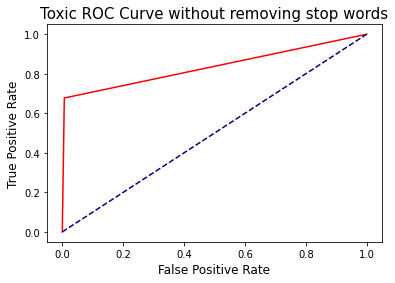

In [18]:
fpr, tpr, thresholds = roc_curve(y_test["toxic"], submission["toxic"])
roc_auc = roc_auc_score(y_test["toxic"], submission["toxic"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Toxic ROC Curve without removing stop words",size=15)
plt.xlabel("False Positive Rate",size=12)
plt.ylabel("True Positive Rate",size=12)
plt.show()

AUC of ROC Curve: 0.6152535357686174


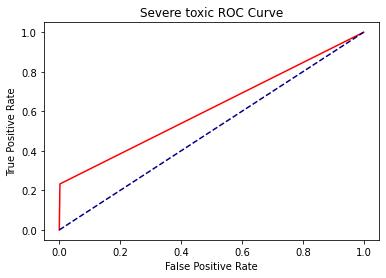

In [19]:
fpr, tpr, thresholds = roc_curve(y_test["severe_toxic"], submission["severe_toxic"])
roc_auc = roc_auc_score(y_test["severe_toxic"], submission["severe_toxic"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Severe toxic ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUC of ROC Curve: 0.8361519500345594


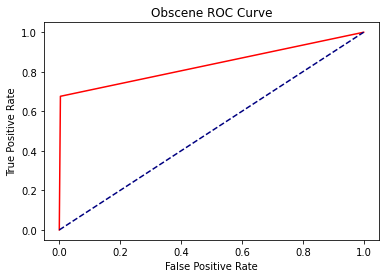

In [20]:
fpr, tpr, thresholds = roc_curve(y_test["obscene"], submission["obscene"])
roc_auc = roc_auc_score(y_test["obscene"], submission["obscene"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Obscene ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUC of ROC Curve: 0.5636569454000335


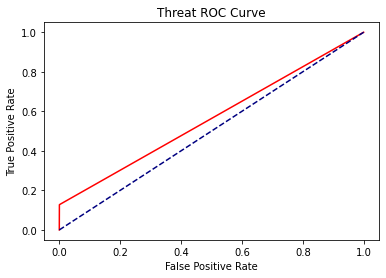

In [22]:
fpr, tpr, thresholds = roc_curve(y_test["threat"], submission["threat"])
roc_auc = roc_auc_score(y_test["threat"], submission["threat"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Threat ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUC of ROC Curve: 0.7862750192641286


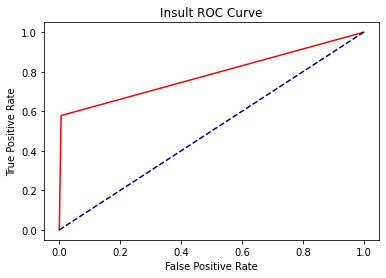

In [23]:
fpr, tpr, thresholds = roc_curve(y_test["insult"], submission["insult"])
roc_auc = roc_auc_score(y_test["insult"], submission["insult"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Insult ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUC of ROC Curve: 0.6178059925926711


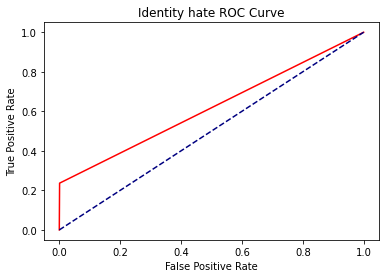

In [24]:
fpr, tpr, thresholds = roc_curve(y_test["identity_hate"], submission["identity_hate"])
roc_auc = roc_auc_score(y_test["identity_hate"], submission["identity_hate"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Identity hate ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Removiendo stop words

In [26]:
# Natural language toolkit, nos ayudara con preprocessing de los datos
import re
import nltk
nltk.download('stopwords')

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Funcion para ayudarnos a sustituir abreviaciones
def decontracted(phrase):
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [0]:
# Set adicional de stopwords, removeremos palabras tanto de este set como del que
# viene definido en el nltk
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Función auxiliar para remover stopwords y otras normalizaciones de texto
def remove_stopwords(dataframe):
  SYNS = []
  for sentance in dataframe:
    sentance = re.sub('\\n', ' ', sentance)
    sentance = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'', sentance)
    sentance = re.sub("\[\[User.*",'',sentance)
    sentance = re.sub("(http://.*?\s)|(http://.*)",'',sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in STOPWORDS)
    SYNS.append(sentance.strip())
  return SYNS

In [0]:
# Remueve stopwords
synops_train = remove_stopwords(train['comment_text'])

In [0]:
train['clean_text'] = synops_train

In [0]:
train2 =train

In [0]:
drop_col = ['id', 'comment_text']  # columns not neccessary - can be dropped
text_col = ['clean_text']  # text feature
label_col = [col for col in train2.columns if col not in text_col + drop_col]

In [34]:
#Dividir train en train y test  20% train y 80% test
import random
random.seed(10)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['clean_text'], 
                                                  train[class_names], test_size=0.2, random_state=2019)

print('Data points in train data after splitting:', len(X_train))
print('Data points in valiadtion data:', len(X_test))

Data points in train data after splitting: 127656
Data points in valiadtion data: 31915


In [0]:
#Se seleccionan las columnas de textos tanto de train como de test
train_text = X_train#train['comment_text']
test_text = X_test#test['comment_text']
all_text = pd.concat([train_text, test_text])  #Aqui se concatenan

## Vectorizar

In [0]:
vectorizer.fit(all_text)  #Esta función se encarga de vectoriza el texto
train_features = vectorizer.transform(train_text)
test_features = vectorizer.transform(test_text)

## Regresión logística

In [37]:
scores = []  
submission = pd.DataFrame.from_dict({'id': X_test.index}) 
for class_name in class_names:
    train_target = y_train[class_name]
    classifier = LogisticRegression(solver='sag')

    cv_score = np.mean(cross_val_score(
        classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1].round()

print('Total CV score is {}'.format(np.mean(scores)))

CV score for class toxic is 0.9774352817034062
CV score for class severe_toxic is 0.9885718126626125
CV score for class obscene is 0.9903323609007274
CV score for class threat is 0.9880352831926897
CV score for class insult is 0.9825342696863331
CV score for class identity_hate is 0.9830585566715878
Total CV score is 0.984994594136226


## Curvas ROC

AUC of ROC Curve: 0.8361350653137096


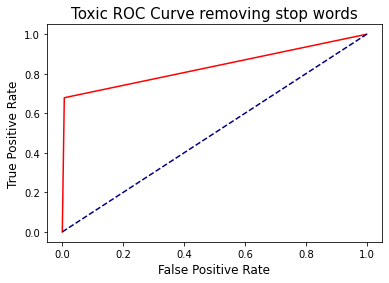

In [38]:
fpr, tpr, thresholds = roc_curve(y_test["toxic"], submission["toxic"])
roc_auc = roc_auc_score(y_test["toxic"], submission["toxic"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Toxic ROC Curve removing stop words",size=15)
plt.xlabel("False Positive Rate",size=12)
plt.ylabel("True Positive Rate",size=12)
plt.show()

AUC of ROC Curve: 0.612137402929932


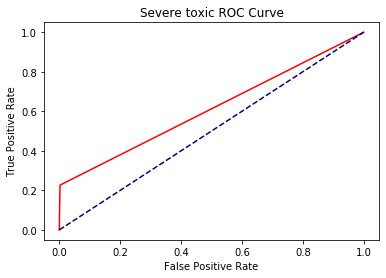

In [0]:
fpr, tpr, thresholds = roc_curve(y_test["severe_toxic"], submission["severe_toxic"])
roc_auc = roc_auc_score(y_test["severe_toxic"], submission["severe_toxic"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Severe toxic ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUC of ROC Curve: 0.8367058235405214


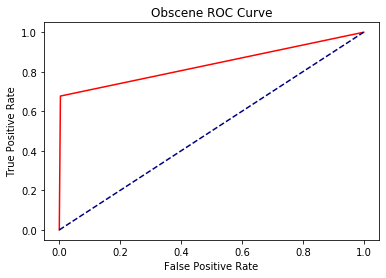

In [0]:
fpr, tpr, thresholds = roc_curve(y_test["obscene"], submission["obscene"])
roc_auc = roc_auc_score(y_test["obscene"], submission["obscene"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Obscene ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUC of ROC Curve: 0.574295243272374


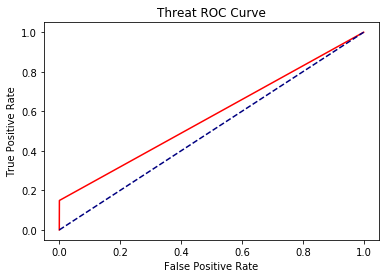

In [0]:
fpr, tpr, thresholds = roc_curve(y_test["threat"], submission["threat"])
roc_auc = roc_auc_score(y_test["threat"], submission["threat"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Threat ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUC of ROC Curve: 0.787666822553354


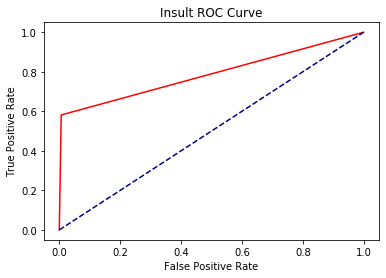

In [0]:
fpr, tpr, thresholds = roc_curve(y_test["insult"], submission["insult"])
roc_auc = roc_auc_score(y_test["insult"], submission["insult"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Insult ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUC of ROC Curve: 0.616181234167478


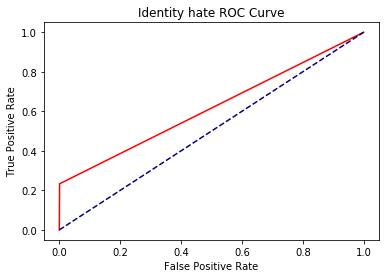

In [0]:
fpr, tpr, thresholds = roc_curve(y_test["identity_hate"], submission["identity_hate"])
roc_auc = roc_auc_score(y_test["identity_hate"], submission["identity_hate"])
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr,'r')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Identity hate ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [0]:
#submission.to_csv('submission.csv', index=False)

Referencias <br>
* https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Xqz2zFMzboz <br>
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html <br>
* https://www.kaggle.com/thousandvoices/logistic-regression-with-words-and-char-n-grams/code <br>